In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

In [2]:
DATA_PATH = "../data/clean_panel.csv"
OUTPUT_DIR = Path("../output")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

WINDOW_MONTHS = 6           
MIN_OBS_FOR_EST = 30        
THRESH_MULTIPLIER = 1.0     
TOP_N_SHOCKS = None   

shock_df = pd.read_csv(OUTPUT_DIR / "shock_beta_summary.csv", parse_dates=['shock_date'])
sigma_file = r"..\output\event_study_outputs\sigma_convergence_event_path.csv"
sigma_df = pd.read_csv(sigma_file)

display(shock_df.head())
display(sigma_df.head())

,shock_date,n_obs,beta,se,half_life_months
0,2020-06-01,396,-0.022012,0.012902,31.141117
1,2020-07-01,396,-0.023481,0.012808,29.170920
2,2020-11-01,396,-0.016139,0.009910,42.602115
3,2020-12-01,396,-0.022634,0.008824,30.276382
4,2021-01-01,396,-0.020905,0.008830,32.809389


,event_time,avg_sigma,shock_date,w_sigma
0,-6,0.044594,2024-05-01,0.043914
1,-5,0.046106,2024-05-01,0.045402
2,-4,0.045833,2024-05-01,0.045133
3,-3,0.045795,2024-05-01,0.045096
4,-2,0.045684,2024-05-01,0.044987


In [3]:
panel = pd.read_csv(DATA_PATH, parse_dates=['Date'])
panel = panel.sort_values(['State','Date']).reset_index(drop=True)

In [4]:
sigma_series = panel.groupby('Date')['relc'].std().reset_index(name='sigma')
sigma_series = sigma_series.dropna().reset_index(drop=True)

In [5]:
if TOP_N_SHOCKS is not None:
    chosen = sigma_series.sort_values('sigma', ascending=False).head(TOP_N_SHOCKS)
    shock_dates = pd.to_datetime(chosen['Date']).sort_values().tolist()
    method_desc = f"Top {TOP_N_SHOCKS} sigma months"
else:
    thr = sigma_series['sigma'].mean() + THRESH_MULTIPLIER * sigma_series['sigma'].std()
    chosen = sigma_series[sigma_series['sigma'] > thr]
    # if none or too few are found, fallback to top 12
    if chosen.empty:
        print("No shocks found with threshold; falling back to top 12 sigma months.")
        chosen = sigma_series.sort_values('sigma', ascending=False).head(12)
    shock_dates = pd.to_datetime(chosen['Date']).sort_values().tolist()
    method_desc = f"Threshold mean + {THRESH_MULTIPLIER}*std (or fallback top12)"

print("Shock detection method:", method_desc)
print("Number of shocks selected:", len(shock_dates))
results = []
for sdate in shock_dates:
    start = sdate - pd.DateOffset(months=WINDOW_MONTHS)
    end   = sdate + pd.DateOffset(months=WINDOW_MONTHS)
    window = panel[(panel['Date'] >= start) & (panel['Date'] <= end)].copy()
    if window.empty:
        continue

    window['lag_rel'] = window.groupby('State')['relc'].shift(1)
    window['d_rel']   = window.groupby('State')['relc'].diff()

    regdata = window.dropna(subset=['lag_rel','d_rel']).copy()
    n_obs = len(regdata)

    if n_obs < MIN_OBS_FOR_EST:
        results.append({
            'shock_date': sdate.date(),
            'n_obs': n_obs,
            'beta': np.nan,
            'se': np.nan,
            'half_life_months': np.nan
        })
        continue

    X = add_constant(regdata['lag_rel'])
    y = regdata['d_rel']
    model = OLS(y, X).fit(cov_type='HC1')   # robust SE
    beta = model.params.get('lag_rel', np.nan)
    se   = model.bse.get('lag_rel', np.nan)

    hl = np.nan
    if (beta is not None) and (-1 < beta < 0):
        try:
            hl = np.log(0.5) / np.log(1 + beta)
        except Exception:
            hl = np.nan

    results.append({
        'shock_date': sdate.date(),
        'n_obs': n_obs,
        'beta': float(beta),
        'se': float(se),
        'half_life_months': float(hl) if not np.isnan(hl) else np.nan
    })

results_df = pd.DataFrame(results).sort_values('shock_date').reset_index(drop=True)
results_df.to_csv(OUTPUT_DIR / "shock_beta_summary.csv", index=False)
print("Saved shock results to:", OUTPUT_DIR / "shock_beta_summary.csv")

Shock detection method: Threshold mean + 1.0*std (or fallback top12)
Number of shocks selected: 24
Saved shock results to: ..\output\shock_beta_summary.csv


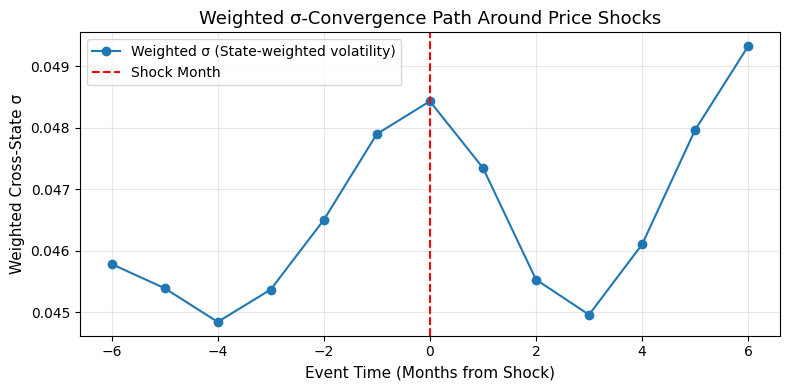

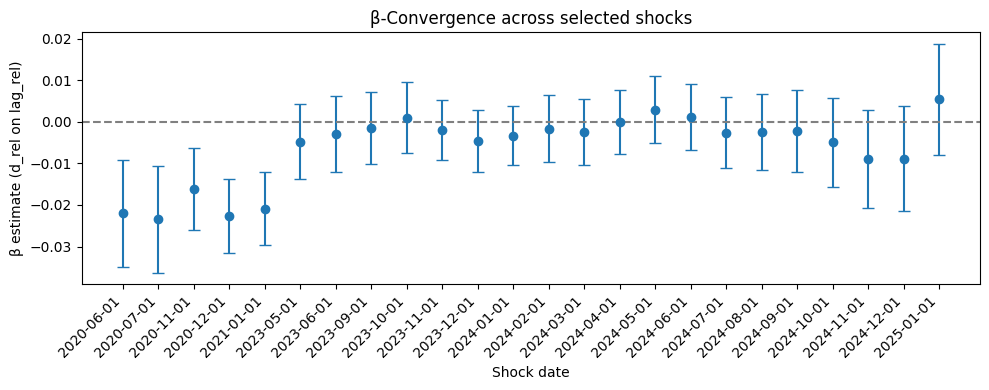

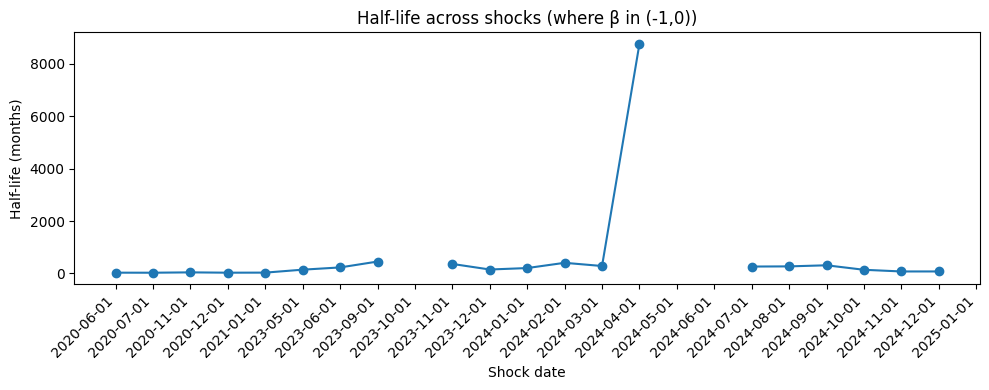

,shock_date,n_obs,beta,se,half_life_months
0,2020-06-01,396,-0.022012,0.012902,31.141117
1,2020-07-01,396,-0.023481,0.012808,29.170920
2,2020-11-01,396,-0.016139,0.009910,42.602115
3,2020-12-01,396,-0.022634,0.008824,30.276382
4,2021-01-01,396,-0.020905,0.008830,32.809389
5,2023-05-01,396,-0.004760,0.009092,145.280982
6,2023-06-01,396,-0.002996,0.009143,231.012565
7,2023-09-01,396,-0.001522,0.008664,455.025496
8,2023-10-01,396,0.001003,0.008583,NaN
9,2023-11-01,396,-0.001903,0.007196,363.922678


In [6]:
avg_w_sigma = sigma_df.groupby('event_time')['w_sigma'].mean().reset_index()
plt.figure(figsize=(8,4))
plt.plot(
    avg_w_sigma['event_time'],    # x-axis
    avg_w_sigma['w_sigma'],       # y-axis
    marker='o',
    color='tab:blue',
    label='Weighted σ (State-weighted volatility)'
)
plt.axvline(0, color='red', linestyle='--', label='Shock Month')
plt.title("Weighted σ-Convergence Path Around Price Shocks", fontsize=13)
plt.xlabel("Event Time (Months from Shock)", fontsize=11)
plt.ylabel("Weighted Cross-State σ", fontsize=11)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# β with errorbars (if se present)
plt.figure(figsize=(10,4))
x = np.arange(len(results_df))
y = results_df['beta']
yerr = results_df['se'].fillna(0)

plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=4)
plt.axhline(0, linestyle='--', color='gray')
plt.xticks(x, results_df['shock_date'].astype(str), rotation=45, ha='right')
plt.xlabel('Shock date')
plt.ylabel('β estimate (d_rel on lag_rel)')
plt.title('β-Convergence across selected shocks')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "beta_across_shocks.png", dpi=160)
plt.show()

# Half-life across shocks
plt.figure(figsize=(10,4))
plt.plot(x, results_df['half_life_months'], marker='o')
plt.xticks(x, results_df['shock_date'].astype(str), rotation=45, ha='right')
plt.xlabel('Shock date')
plt.ylabel('Half-life (months)')
plt.title('Half-life across shocks (where β in (-1,0))')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "half_life_across_shocks.png", dpi=160)
plt.show()

display(results_df)